In [1]:
import os ; import pathlib as pl ; import flopy ; import matplotlib.pyplot as plt ; import numpy as np; from flopy.utils.lgrutil import Lgr  
from matplotlib.colors import ListedColormap ; from pathlib import Path; from flopy.plot.styles import styles ; import pandas as pd 
import matplotlib as mpl; from modflow_devtools.misc import get_env, timed 
write=get_env("WRITE",True);run=get_env("RUN",True);plot=get_env("PLOT",True);plot_show=get_env("PLOT_SHOW",True);plot_save=get_env("PLOT_SAVE",True)

In [2]:
sim_ws = Path("./14_lak-p01") ; sim_ws.mkdir(exist_ok=True) ; sim_name = "ex-gwf-lak-p01"
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; workspace = figs_path = sim_ws ; gwf_name = sim_name 
#path = 'E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-sfr-pindersauer' ; 
#aux_ws = Path("./_aux") ; fpath1 = os.path.join(path,"delr.txt") 

In [3]:
length_units = "feet"; 
time_units = "days"  ; 

nlay = 5  # Number of layers
nrow = 17  # Number of rows
ncol = 17  # Number of columns
top = 500.0  # Top of the model ($ft$)
botm_str = "107., 97., 87., 77., 67."  # Bottom elevations ($ft$)
strt = 115.0  # Starting head ($ft$)
k11 = 30.0  # Horizontal hydraulic conductivity ($ft/d$)
k33_str = "1179., 30., 30., 30., 30."  # Vertical hydraulic conductivity ($ft/d$)
ss = 3e-4  # Specific storage ($1/d$)
sy = 0.2  # Specific yield (unitless)
H1 = 160.0  # Constant head on left side of model ($ft$)
H2 = 140.0  # Constant head on right side of model ($ft$)
recharge = 0.0116  # Aereal recharge rate ($ft/d$)
etvrate = 0.0141  # Maximum evapotranspiration rate ($ft/d$)
etvdepth = 15.0  # Evapotranspiration extinction depth ($ft$)
lak_strt = 110.0  # Starting lake stage ($ft$)
lak_etrate = 0.0103  # Lake evaporation rate ($ft/d$)
lak_bedleak = 0.1  # Lakebed leakance ($1/d$)
nouter = 500
ninner = 100
hclose = 1e-9
rclose = 1e-6

botm = [float(value) for value in botm_str.split(",")]
k33 = [float(value) for value in k33_str.split(",")]

nper = 1  
tdis_ds = ((5000.0, 100, 1.02),)

delr = np.array([250,1000,1000,1000,1000,1000,5000,5000,5000,500,5000,1000,1000,1000,1000,1000,250])
delc = np.array([250,1000,1000,1000,1000,1000,5000,5000,5000,500,5000,1000,1000,1000,1000,1000,250])

extents = (0.0, delr.sum(), 0.0, delc.sum())
shape2d = (nrow, ncol)
shape3d = (nlay, nrow, ncol)

lake_map = np.ones(shape3d, dtype=np.int32) * -1  
lake_map[0, 6:11, 6:11] = 0 ; lake_map[1, 7:10, 7:10] = 0  ; lake_map = np.ma.masked_where(lake_map < 0, lake_map)

xlen = delr.sum() - 0.5 * (delr[0] + delr[-1])  ; x = 0.0  ; s1d = H1 * np.ones(ncol, dtype=float)
for idx in range(1, ncol):
    x += 0.5 * (delr[idx - 1] + delr[idx])  ; frac = x / xlen ; s1d[idx] = H1 + (H2 - H1) * frac
surf = np.tile(s1d, (nrow, 1)) ; surf[lake_map[0] == 0] = botm[0] - 2 ; surf[lake_map[1] == 0] = botm[1] - 2

chd_spd = []
for k in range(nlay):
    chd_spd += [[k, i, 0, H1] for i in range(nrow)]   ; chd_spd += [[k, i, ncol - 1, H2] for i in range(nrow)]

lak_spd = [[0, "rainfall", recharge],[0, "evaporation", lak_etrate]]



### Model setup

Define functions to build models, write input files, and run the simulation.

In [4]:
def build_models():
#   sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        linear_acceleration="bicgstab",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=sim_name, newtonoptions="newton", save_flows=True
    )
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        idomain=np.ones(shape3d, dtype=int),
        top=top,
        botm=botm,
    )
    obs_file = f"{sim_name}.gwf.obs"
    csv_file = obs_file + ".csv"
    obslist = [
        ["A", "head", (0, 3, 3)],
        ["B", "head", (0, 13, 13)],
    ]
    obsdict = {csv_file: obslist}
    flopy.mf6.ModflowUtlobs(
        gwf, filename=obs_file, print_input=False, continuous=obsdict
    )

    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=1,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfsto(
        gwf,
        iconvert=1,
        sy=sy,
        ss=ss,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)
    flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
    flopy.mf6.ModflowGwfevta(gwf, surface=surf, rate=etvrate, depth=etvdepth)
    (idomain_wlakes, pakdata_dict, lak_conn) = flopy.mf6.utils.get_lak_connections(
        gwf.modelgrid, lake_map, bedleak=lak_bedleak
    )
    lak_packagedata = [[0, lak_strt, pakdata_dict[0]]]
    lak = flopy.mf6.ModflowGwflak(
        gwf,
        print_stage=True,
        nlakes=1,
        noutlets=0,
        packagedata=lak_packagedata,
        connectiondata=lak_conn,
        perioddata=lak_spd,
    )
    obs_file = f"{sim_name}.lak.obs"
    csv_file = obs_file + ".csv"
    obs_dict = {
        csv_file: [
            ("stage", "stage", (0,)),
        ]
    }
    lak.obs.initialize(
        filename=obs_file, digits=10, print_input=True, continuous=obs_dict
    )
    gwf.dis.idomain = idomain_wlakes

    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    )
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Model setup

Define functions to build models, write input files, and run the simulation.

In [5]:
# Figure properties
figure_size = (6.3, 5.6)
masked_values = (0, 1e30, -1e30)


def plot_grid(gwf, silent=True):
    # load the observations
    lak_results = gwf.lak.output.obs().data

    # create MODFLOW 6 head object
    hobj = gwf.output.head()

    # create MODFLOW 6 cell-by-cell budget object
    cobj = gwf.output.budget()

    kstpkper = hobj.get_kstpkper()

    head = hobj.get_data(kstpkper=kstpkper[0])
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=kstpkper[0])[0], gwf
    )

    # add lake stage to heads
    head[head == 1e30] = lak_results["STAGE"][-1]

    # observation locations
    xcenters, ycenters = gwf.modelgrid.xycenters[0], gwf.modelgrid.xycenters[1]
    p1 = (xcenters[3], ycenters[3])
    p2 = (xcenters[13], ycenters[13])

    with styles.USGSMap():
        fig = plt.figure(figsize=(4, 6.9), tight_layout=True)
        plt.axis("off")

        nrows, ncols = 10, 1
        axes = [fig.add_subplot(nrows, ncols, (1, 5))]
        axes.append(fig.add_subplot(nrows, ncols, (6, 8), sharex=axes[0]))

        for idx, ax in enumerate(axes):
            ax.set_xlim(extents[:2])
            if idx == 0:
                ax.set_ylim(extents[2:])
                ax.set_aspect("equal")

        # legend axis
        axes.append(fig.add_subplot(nrows, ncols, (9, 10)))

        # set limits for legend area
        ax = axes[-1]
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        # get rid of ticks and spines for legend area
        ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_color("none")
        ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)

        ax = axes[0]
        mm = flopy.plot.PlotMapView(gwf, ax=ax, extent=extents)
        mm.plot_bc("CHD", color="cyan")
        mm.plot_inactive(color_noflow="#5DBB63")
        mm.plot_grid(lw=0.5, color="black")
        cv = mm.contour_array(
            head,
            levels=np.arange(140, 160, 2),
            linewidths=0.75,
            linestyles="-",
            colors="blue",
            masked_values=masked_values,
        )
        plt.clabel(cv, fmt="%1.0f")
        mm.plot_vector(qx, qy, normalize=True, color="0.75")
        ax.plot(p1[0], p1[1], marker="o", mfc="red", mec="black", ms=4)
        ax.plot(p2[0], p2[1], marker="o", mfc="red", mec="black", ms=4)
        ax.set_xlabel("x-coordinate, in feet")
        ax.set_ylabel("y-coordinate, in feet")
        styles.heading(ax, heading="Map view", idx=0)
        styles.add_text(
            ax,
            "A",
            x=p1[0] + 150,
            y=p1[1] + 150,
            transform=False,
            bold=False,
            color="red",
            ha="left",
            va="bottom",
        )
        styles.add_text(
            ax,
            "B",
            x=p2[0] + 150,
            y=p2[1] + 150,
            transform=False,
            bold=False,
            color="red",
            ha="left",
            va="bottom",
        )
        styles.remove_edge_ticks(ax)

        ax = axes[1]
        xs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": 8})
        xs.plot_array(np.ones(shape3d), head=head, cmap="jet")
        xs.plot_bc("CHD", color="cyan", head=head)
        xs.plot_ibound(color_noflow="#5DBB63", head=head)
        xs.plot_grid(lw=0.5, color="black")
        ax.set_xlabel("x-coordinate, in feet")
        ax.set_ylim(67, 160)
        ax.set_ylabel("Elevation, in feet")
        styles.heading(ax, heading="Cross-section view", idx=1)
        styles.remove_edge_ticks(ax)

        # legend
        ax = axes[-1]
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="#5DBB63",
            mec="black",
            markeredgewidth=0.5,
            label="Lake boundary",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="cyan",
            mec="black",
            markeredgewidth=0.5,
            label="Constant-head boundary",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="s",
            ms=10,
            mfc="blue",
            mec="black",
            markeredgewidth=0.5,
            label="Water table",
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="o",
            ms=4,
            mfc="red",
            mec="black",
            markeredgewidth=0.5,
            label="Observation well",
        )
        ax.plot(
            -10000, -10000, lw=0.75, ls="-", color="blue", label=r"Head contour, $ft$"
        )
        ax.plot(
            -10000,
            -10000,
            lw=0,
            marker="$\u2192$",
            ms=10,
            mfc="0.75",
            mec="0.75",
            label="Normalized specific discharge",
        )
        styles.graph_legend(ax, loc="lower center", ncol=2)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)


def plot_lak_results(gwf, silent=True):
    with styles.USGSPlot():
        # load the observations
        lak_results = gwf.lak.output.obs().data
        gwf_results = gwf.obs[0].output.obs().data

        dtype = [
            ("time", float),
            ("STAGE", float),
            ("A", float),
            ("B", float),
        ]

        results = np.zeros((lak_results.shape[0] + 1), dtype=dtype)
        results["time"][1:] = lak_results["totim"]
        results["STAGE"][0] = 110.0
        results["STAGE"][1:] = lak_results["STAGE"]
        results["A"][0] = 115.0
        results["A"][1:] = gwf_results["A"]
        results["B"][0] = 115.0
        results["B"][1:] = gwf_results["B"]

        # create the figure
        fig, ax = plt.subplots(
            ncols=1, nrows=1, sharex=True, figsize=(6.3, 3.15), constrained_layout=True
        )

        ax.set_xlim(0, 3000)
        ax.set_ylim(110, 160)
        ax.plot(
            results["time"],
            results["STAGE"],
            lw=0.75,
            ls="--",
            color="black",
            label="Lake stage",
        )
        ax.plot(
            results["time"], results["A"], lw=0.75, ls="-", color="0.5", label="Point A"
        )
        ax.plot(
            results["time"],
            results["B"],
            lw=0.75,
            ls="-",
            color="black",
            label="Point B",
        )
        ax.set_xlabel("Simulation time, in days")
        ax.set_ylabel("Head or stage, in feet")
        styles.graph_legend(ax, loc="lower right")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-01.png"
            fig.savefig(fpth)


def plot_results(sim, silent=True):
    gwf = sim.get_model(sim_name)
    plot_grid(gwf, silent=silent)
    plot_lak_results(gwf, silent=silent)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 9752.91 ms


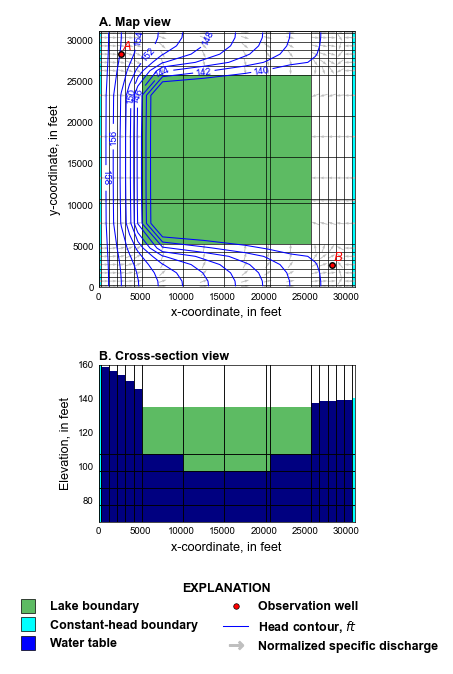

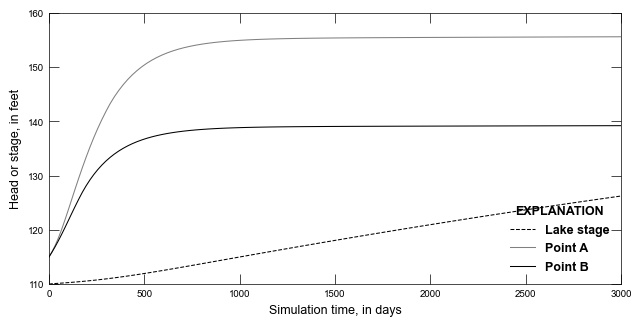

In [6]:
def scenario(silent=True):
    sim = build_models()
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, silent=silent)


scenario()